# Example notebook to decode & mapping MOD02 & MOD35 data
Simple instruction to help your project about 2 questions 
1. How to decode HDF MODIS data ?
2. How to process and map them?

-------------

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as mpl_patches
from pyhdf.SD import SD, SDC 

In [2]:
# directory where your put lib_hdfs
# e.g. /home/tkurihana/src/src_share/lib_hdfs
homedir='/home/tkurihana/src/src_share/lib_hdfs'

Load Takuya' functions to decode MODIS data

In [43]:
sys.path.insert(1,os.path.join(sys.path[0],homedir))
from alignment_lib import gen_mod02_img_sigle,  gen_mod35_img_single
from alignment_lib import mod02_proc_sds_single
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array

------------------------
### Load data and extract patches where cloud pixel accounts for more than 30 % 

In [16]:
# set directory path
mod02_hdfdir = homedir+'/mod02_20150628'
mod35_hdfdir = homedir+'/mod35_20150628'
date = '2015179'

In [35]:
# genetate numpy array for mod02, mod35 data
mod02_img = gen_mod02_img_sigle(hdf_datadir=mod02_hdfdir, date=date)
clouds_mask_img = gen_mod35_img_single(hdf_datadir=mod35_hdfdir, date=date)

# generate patch
## NO normalization to preserve original radiance strength 
mod02_patches = _gen_patches(mod02_img, normalization=False)

# cloud patches with at least ${thres} percent of cloud flag within patch
thres = 0.3 # range [0.0 - 1.0] floating points. 0.3 is optimal
clouds_patches_list, clouds_xy_list = const_clouds_array(mod02_patches, clouds_mask_img, thres=thres)

Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31


### Mapping patches with more than 30%

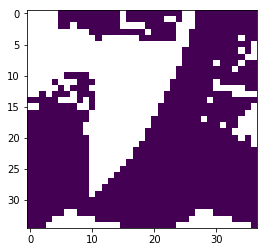

In [45]:
# reconstruct img array from list
ix, iy = mod02_patches.shape[:2]
cimg_array = np.zeros((ix,iy)).astype(np.float64)
cimg_array[:,:] = np.nan
for idx, (x,y) in enumerate(clouds_xy_list):
    cimg_array[x,y] = 0  # input is 0 if there is a cloud (0 corresponds to color-list index afterwords)
    
plt.imshow(cimg_array)

### Load a visible band data

( Additional Problem1 ) Try to make below process into a function  
e.g.  
``` def gen_visible():
       Input:  hdf data directory path (string)
       Input:  decode data's date (string)
       Output: decoded hdf data (numpy array)
```

In [44]:
# load visible band (band 1 out of 36)
hdf_datadir = mod02_hdfdir
vis_file = glob.glob(
        hdf_datadir+'/MOD021KM.A'+date+'.mosaic.061.*.EV_250_Aggr1km_RefSB_1.hdf'
    )[0]

# get hdf data  
vhdf = SD(vis_file, SDC.READ)

# get sds (science data structure) data
vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")

#
vhdf_array, vis_band = mod02_proc_sds_single(vhdf_sds)

Process bands 1


### Mapping data onto visible image

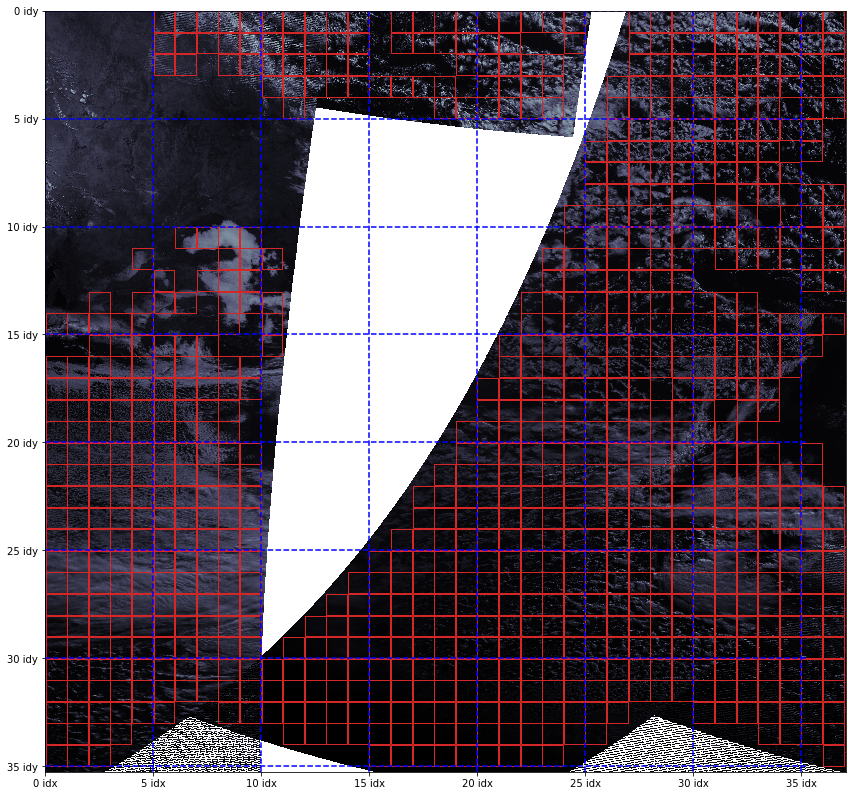

In [100]:
fig = plt.figure(figsize=(12,12))

# set params
xmin, ymin = 0, 0
xmax, ymax = vhdf_array.shape
linerange = 5 # every 10 patches, draw line

patches   = mod02_patches
img_array = cimg_array

line_width = 2
SHAPE = 128,128
colors = ['#d62728']  # <-- here number of color-list is just 1 cimg_array[i,j] = {0, nan} 
ax = plt.subplot(1,1,1)
plt.hlines([i for i in range(0,xmax, 128*linerange)], xmin, xmax, "blue", linestyles='dashed')
plt.vlines([i for i in range(0,ymax, 128*linerange)], ymin, ymax, "blue", linestyles='dashed')
plt.imshow(vhdf_array, cmap='bone')
plt.xticks( np.arange(0,xmax,128*linerange), 
           [str(idx*linerange)+' idx' for idx, i in enumerate( np.arange(0,xmax,128*linerange)) ] )
plt.yticks( np.arange(0,ymax,128*linerange), 
           [str(idy*linerange)+' idy' for idy, i in enumerate( np.arange(0,ymax,128*linerange)) ] )

for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        if not np.isnan(img_array[i,j]):
            ax.add_patch(mpl_patches.Rectangle(
                    (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(img_array[i,j])],
                      facecolor="none"                 
                    )
            )



fig.tight_layout()
plt.show()

Check individual patch
* Be careful for patch index relation

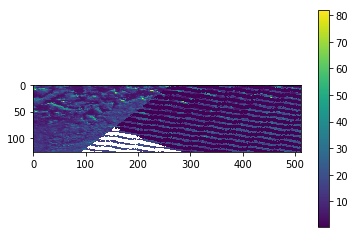

In [99]:
# vhdf_array ==> [idy : idx]
plt.imshow(vhdf_array[32*128:33*128,27*128:31*128])
#plt.imshow(vhdf_array[30*128:31*128,30*128:31*128])
plt.colorbar()

## Assignment
1. Load filename automatically once user inputs a directory path which has several~hundreds of files
2. Location input seems little bit tricky for me (Sometimes takes time if patches locate at center of the entire image).  
    How to prevent mistakes when user inputs location of patches?  
   (*Matplotlibe automatically scale colors. Becareful if you split entire filed and plot them individually)
3. Const_clouds_array is very slow. Make the function faster. Use parallel-libraries?
4. 